In [45]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

In [46]:
df = pd.read_parquet('C:/Users/boban/OneDrive/Desktop/S8/Classes/DLP/DL_Project/data/vivino_wines_with_weather.parquet')
df.head()

# Number of lines in the DataFrame
num_lines = len(df) 
print(f"Total number of lines in the DataFrame: {num_lines}")


Total number of lines in the DataFrame: 10055


In [48]:
# -------------------------------
# 1. Build 50-km neighbourhoods
# -------------------------------
R_EARTH = 6371  # km
coords_rad = np.radians(df[['latitude', 'longitude']])
tree = BallTree(coords_rad, metric='haversine')

radius = 50 / R_EARTH          # 50-km in radians
clusters = tree.query_radius(coords_rad, r=radius)

# Map each index to the “smallest” cluster id so that overlapping
# neighbourhoods collapse into one community (simple union-find)
parent = list(range(len(df)))
def find(i):
    while parent[i] != i:
        parent[i] = parent[parent[i]]
        i = parent[i]
    return i
for i, neigh in enumerate(clusters):
    for j in neigh:
        root_i, root_j = find(i), find(j)
        if root_i != root_j:
            parent[root_j] = root_i
cluster_id = [find(i) for i in range(len(df))]
df['cluster_id'] = cluster_id

# -------------------------------
# 2. Print grouped region names
# -------------------------------
group_map = (df.groupby('cluster_id')['region']
               .apply(lambda x: sorted(set(x)))
               .to_dict())

print("=== New 'neighbourhood' groups ===")
for cid, regions in group_map.items():
    print(f"Cluster {cid:>4}: {', '.join(regions)}")
    
# print the number of clusters
print(f"\nTotal number of clusters: {len(set(cluster_id))}")


=== New 'neighbourhood' groups ===
Cluster    0: blaye, blaye-cotes-de-bordeaux, bordeaux, bordeaux-superieur, cadillac-cotes-de-bordeaux, chambolle-musigny-aux-combottes, cotes-de-bordeaux, cotes-de-bourg, cotes-de-castillon, cotes-du-rhone-villages-valreas, fronsac, graves, graves-de-vayres, haut-medoc, libournais, listrac, lussac-st-emilion, margaux, medoc, montagne-saint-emilion, pauillac, pessac-leognan, pomerol, premieres-cotes-de-bordeaux, puisseguin-saint-emilion, saint-emilion, saint-georges-saint-emilion, saint-julien, sainte-foy-bordeaux, southwest
Cluster   17: cahors
Cluster   59: anjou, anjou-villages-brissac, bourgueil, chinon, loire-valley, saint-nicolas-de-bourgueil, saumur, saumur-champigny, touraine, touraine-amboise
Cluster  269: madiran
Cluster  332: aloxe-corton, aloxe-corton-clos-du-chapitre, aloxe-corton-la-toppe-au-vert, aloxe-corton-les-chaillots, aloxe-corton-les-fournieres, aloxe-corton-les-marechaudes, aloxe-corton-les-moutottes, aloxe-corton-les-petites-lo

In [50]:
#number of wines by cluster
wines_by_cluster = df.groupby('cluster_id').size().reset_index(name='num_wines')
print("\n=== Number of wines by cluster ===")
print(wines_by_cluster.sort_values(by='num_wines', ascending=False))

# delete wines from clusters with less than 40 wines
min_wines = 40
df = df[df['cluster_id'].isin(wines_by_cluster[wines_by_cluster['num_wines'] >= min_wines]['cluster_id'])]
# print the number of clusters after filtering
print(f"\nTotal number of clusters after filtering: {len(set(df['cluster_id']))}")



=== Number of wines by cluster ===
   cluster_id  num_wines
8        1432       3232
4         332       3126
0           0       2219
5         645        508
2          59        414
6         740         98
1          17         97
7        1224         90
9        1564         75
3         269         48

Total number of clusters after filtering: 10


In [51]:
# Number of lines in the DataFrame
num_lines = len(df) 
print(f"Total number of lines in the DataFrame: {num_lines}")

Total number of lines in the DataFrame: 9907


In [52]:
df.head()

,Winery,Wine,year,vintage_rating,vintage_rating_count,wine_rating_count,wine_rating,region,price,cepages,...,TX_summer,temp_amp_summer,hot_days,rainy_days_summer,rain_June,rain_SepOct,frost_days_Apr,avg_TM_Apr,dist_km,cluster_id
0,Château de Lavagnac,Bordeaux 2015,2015.0,3.6,76,766,3.5,bordeaux,4.1,cabernet-sauvignon,...,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,5.317702,0
1,Château de Callac,Graves Rouge 2011,2011.0,3.6,221,3008,3.7,graves,4.5,cabernet-sauvignon,...,26.356452,11.301613,2.0,5.0,55.5,94.5,0.0,15.750000,8.479655,0
2,Château Gravelier,Bordeaux Rouge 2022,2022.0,3.4,621,621,3.4,bordeaux,4.9,cabernet-sauvignon,...,32.291935,13.583871,17.0,1.0,110.8,82.4,0.0,13.300000,1.517761,0
3,Château de Brandey,Bordeaux Rouge 2015,2015.0,3.6,333,1705,3.4,bordeaux,4.9,cabernet-sauvignon,...,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,5.317702,0
4,Les Hauts de Palette,Château Haut-Mondain Bordeaux Rouge 2016,2016.0,3.4,258,1919,3.6,bordeaux,4.9,cabernet-sauvignon,...,28.667742,12.424194,8.0,0.0,74.5,81.5,0.0,11.876667,5.317702,0


In [64]:
def add_quality_indicator(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.copy()
    
    df["price_log"] = np.log1p(df["price"])

    grp = df.groupby(["region", "cepages"])
    df["μ_price"] = grp["price_log"].transform("mean")
    df["σ_price"] = grp["price_log"].transform("std").replace(0, np.nan)
    df["μ_rate"]  = grp["vintage_rating"].transform("mean")
    df["σ_rate"]  = grp["vintage_rating"].transform("std").replace(0, np.nan)


    df["z_price"]  = (df["price_log"] - df["μ_price"]) / df["σ_price"]
    df["z_rating"] = (df["vintage_rating"]    - df["μ_rate"])  / df["σ_rate"]


    df["w"] = np.log1p(df["vintage_rating_count"])
    df["z_rating_conf"] = df["z_rating"] * df["w"]

    df["QI"] = 0.50 * df["z_rating_conf"] + 0.50 * (-df["z_price"])

    cols_to_drop = ["price_log", "μ_price", "σ_price", "μ_rate",
                    "σ_rate", "z_price", "z_rating", "w", "z_rating_conf"]
    return df.drop(columns=cols_to_drop, errors="ignore")

df_with_qi = add_quality_indicator(df)

In [65]:
df_with_qi.head()

,Winery,Wine,year,vintage_rating,vintage_rating_count,wine_rating_count,wine_rating,region,price,cepages,...,temp_amp_summer,hot_days,rainy_days_summer,rain_June,rain_SepOct,frost_days_Apr,avg_TM_Apr,dist_km,cluster_id,QI
0,Château de Lavagnac,Bordeaux 2015,2015.0,3.6,76,766,3.5,bordeaux,4.1,cabernet-sauvignon,...,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,5.317702,0,-0.044013
1,Château de Callac,Graves Rouge 2011,2011.0,3.6,221,3008,3.7,graves,4.5,cabernet-sauvignon,...,11.301613,2.0,5.0,55.5,94.5,0.0,15.750000,8.479655,0,-2.646958
2,Château Gravelier,Bordeaux Rouge 2022,2022.0,3.4,621,621,3.4,bordeaux,4.9,cabernet-sauvignon,...,13.583871,17.0,1.0,110.8,82.4,0.0,13.300000,1.517761,0,-2.696392
3,Château de Brandey,Bordeaux Rouge 2015,2015.0,3.6,333,1705,3.4,bordeaux,4.9,cabernet-sauvignon,...,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,5.317702,0,-0.448390
4,Les Hauts de Palette,Château Haut-Mondain Bordeaux Rouge 2016,2016.0,3.4,258,1919,3.6,bordeaux,4.9,cabernet-sauvignon,...,12.424194,8.0,0.0,74.5,81.5,0.0,11.876667,5.317702,0,-2.230059


In [66]:
df_with_qi.head(100)

def get_extreme_qi(df: pd.DataFrame, k: int = 3):
    
    if "QI" not in df.columns:
        raise ValueError("Run add_quality_indicator() first – dataframe has no 'QI' column.")

    best  = df.nlargest(k, "QI")
    worst = df.nsmallest(k, "QI")
    return best, worst

best_wine, worst_wine = get_extreme_qi(df_with_qi)     # default k=1
print("Top QI:\n",   best_wine)
print("\nLowest QI:\n", worst_wine)







Top QI:
                   Winery                                             Wine  \
9880     Château Margaux  Château Margaux (Premier Grand Cru Classé) 2022   
9408  Château Haut-Brion   Pessac-Léognan (Premier Grand Cru Classé) 2024   
9870  Château Haut-Brion   Pessac-Léognan (Premier Grand Cru Classé) 2022   

        year  vintage_rating  vintage_rating_count  wine_rating_count  \
9880  2022.0             4.6                 53109              53109   
9408  2024.0             4.6                 46592              46592   
9870  2022.0             4.6                 46592              46592   

      wine_rating          region  price             cepages  ...  \
9880          4.6         margaux  899.8  cabernet-sauvignon  ...   
9408          4.6  pessac-leognan  336.0  cabernet-sauvignon  ...   
9870          4.6  pessac-leognan  880.0  cabernet-sauvignon  ...   

      temp_amp_summer  hot_days rainy_days_summer rain_June rain_SepOct  \
9880        14.404839      16.0      

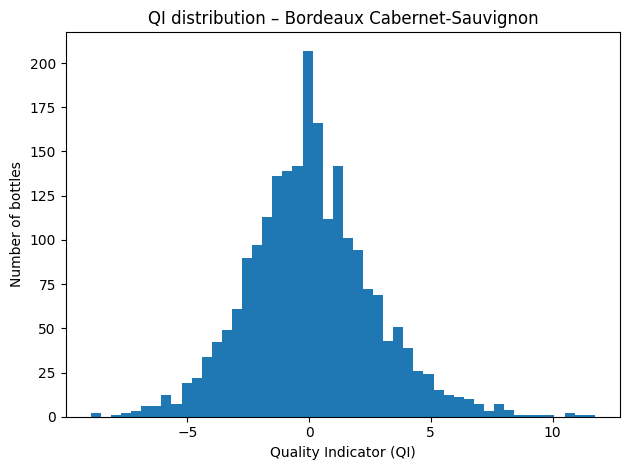

In [71]:
import matplotlib.pyplot as plt

# Replace `df_with_qi` with your dataframe variable if it’s named differently
mask = (
    df_with_qi["cluster_id"].eq(0)
    & df_with_qi["cepages"].str.lower().str.contains("cabernet-sauvignon")
)

subset = df_with_qi.loc[mask, "QI"].dropna()

if subset.empty:
    print("No Bordeaux Cabernet‑Sauvignon wines found in the dataframe.")
else:
    plt.figure()
    plt.hist(subset, bins=50)
    plt.title("QI distribution – Bordeaux Cabernet‑Sauvignon")
    plt.xlabel("Quality Indicator (QI)")
    plt.ylabel("Number of bottles")
    plt.tight_layout()
    plt.show()


In [73]:
# --- Filter Bordeaux rows for the vintages of interest -------------------
mask = (
    (df_with_qi["region"].str.lower() == "bordeaux")  # region filter
    & df_with_qi["year"].between(2010, 2024)       # year filter
)

# --- Mean QI per vintage --------------------------------------------------
year_qi = (
    df_with_qi.loc[mask]
              .groupby("year")["QI"]
              .mean()
              .dropna()        # drop years with no data
)

# --- Identify the extremes ------------------------------------------------
best_year  = year_qi.idxmax()
worst_year = year_qi.idxmin()

print(f"Best Bordeaux vintage (2010-24):  {best_year}  — mean QI = {year_qi[best_year]:.3f}")
print(f"Worst Bordeaux vintage (2010-24): {worst_year} — mean QI = {year_qi[worst_year]:.3f}")


Best Bordeaux vintage (2010-24):  2020.0  — mean QI = 0.524
Worst Bordeaux vintage (2010-24): 2024.0 — mean QI = -6.686


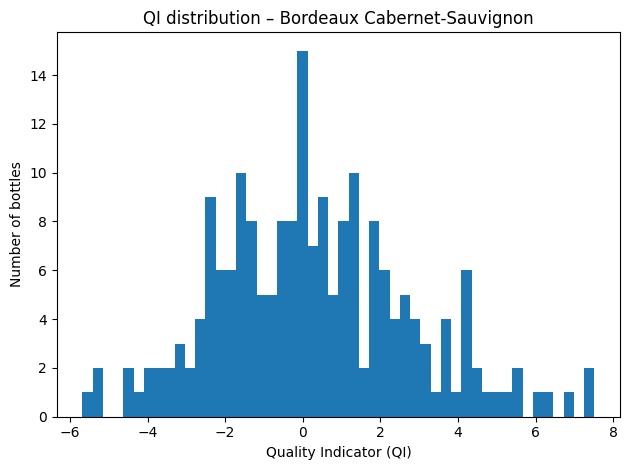

In [74]:
# Replace `df_with_qi` with your dataframe variable if it’s named differently
mask = (
    df_with_qi["cluster_id"].eq(0)
    & df_with_qi["cepages"].str.lower().str.contains("cabernet-sauvignon")
    & df_with_qi['year'].eq(2016)
)

subset = df_with_qi.loc[mask, "QI"].dropna()

if subset.empty:
    print("No Bordeaux Cabernet‑Sauvignon wines found in the dataframe.")
else:
    plt.figure()
    plt.hist(subset, bins=50)
    plt.title("QI distribution – Bordeaux Cabernet‑Sauvignon")
    plt.xlabel("Quality Indicator (QI)")
    plt.ylabel("Number of bottles")
    plt.tight_layout()
    plt.show()

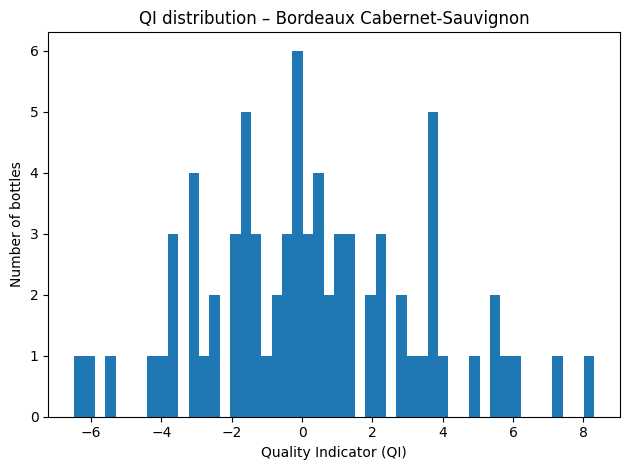

In [77]:
# Replace `df_with_qi` with your dataframe variable if it’s named differently
mask = (
    df_with_qi["cluster_id"].eq(0)
    & df_with_qi["cepages"].str.lower().str.contains("cabernet-sauvignon")
    & df_with_qi['year'].eq(2012)
)

subset = df_with_qi.loc[mask, "QI"].dropna()

if subset.empty:
    print("No Bordeaux Cabernet‑Sauvignon wines found in the dataframe.")
else:
    plt.figure()
    plt.hist(subset, bins=50)
    plt.title("QI distribution – Bordeaux Cabernet‑Sauvignon")
    plt.xlabel("Quality Indicator (QI)")
    plt.ylabel("Number of bottles")
    plt.tight_layout()
    plt.show()